# Model Experimentation 5: WaldoNet/Custom Head

In this next iteration, we use the aforementioned custom Waldo head along with the new WaldoNet architecture (pretrained).

In [1]:
import IPython.core.display as di
from IPython.display import Markdown as md

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )
    
def md_cat(file_path):
    with open(file_path) as file:
        return md(f"```python\n{file.read()}\n```")

toggle_code()

Toggle code

In [2]:
import json
import os
import sys
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
from cached_property import cached_property
from matplotlib import patches
from PIL import Image
from tqdm.notebook import tqdm, trange

In [3]:
data_path = "../data"
sys.path.append(data_path)

In [4]:
from Dataset import Dataset, TestDataset, originals, boxes
from LossAccumulator import LossAccumulator
from Parameters import Parameters
from PolyLearningRateDecay import PolyLearningRateDecay
from WaldoNet import WaldoNet

## Parameters

In [5]:
params = Parameters("params.yml")

In [6]:
assert params.use_gpu

In [7]:
log = params.get_logger('Model_v5_pretrain')

In [8]:
if not os.path.isdir(params.save_model_path):
    os.mkdir(params.save_model_path)

## Load Data

See the [data augmentation notebook](https://github.com/antoniojkim/WheresWaldo-YoloV3/blob/master/data/data.ipynb) for more details on how the data was curated and augmented.

In [9]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_inverse(y):
    return np.log(y/(1-y))

In [10]:
S = 16

class DatasetV5(Dataset):  # Same as DatasetV4
    
    @cached_property
    def bounding_box_prior_x(self):
        return np.mean([d['box']['x'] for d in self.data if 'box' in d])
    
    @cached_property
    def bounding_box_prior_y(self):
        return np.mean([d['box']['y'] for d in self.data if 'box' in d])
    
    @cached_property
    def bounding_box_prior_width(self):
        return np.mean([d['box']['w'] for d in self.data if 'box' in d])
    
    @cached_property
    def bounding_box_prior_height(self):
        return np.mean([d['box']['h'] for d in self.data if 'box' in d])
    
    def get_label(self, index, image):
        if "box" in self.data[index]:
            box = self.data[index]["box"]            
            b_x, b_y, b_w, b_h = box["x"], box["y"], box["w"], box["h"]
            box_prob = 1
        else:
            b_x = self.bounding_box_prior_x
            b_y = self.bounding_box_prior_y
            b_w = self.bounding_box_prior_width
            b_h = self.bounding_box_prior_height
            box_prob = 0
            
        center_x = b_x + b_w // 2
        center_y = b_y + b_h // 2

        image_c, image_h, image_w = image.shape
        S_w = int(image_w // (S - 1))
        S_h = int(image_h // (S - 1))

        i = int(center_x // S_w)
        j = int(center_y // S_h)

        locale = i * (S-1) + j

        if i < S and j < S:
            t_x = (center_x - S_w * i) / S_w
            t_y = (center_y - S_h * j) / S_h
            t_w = np.log(b_w / self.bounding_box_prior_width)
            t_h = np.log(b_h / self.bounding_box_prior_height)

            return locale, torch.tensor((t_x, t_y, t_w, t_h, box_prob))
        else:
            raise ValueError("Invalid i, j: ", (i, j), "  Expected: ", S)
    
np.random.seed(20200509)
dataset = DatasetV5(ntimes=100)
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

In [11]:
test_dataloader = torch.utils.data.DataLoader(
    TestDataset(),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = False,
    drop_last   = True
)

## Model Definition

In [12]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [13]:
# waldonet = WaldoNet(".checkpoints/WaldoNet_pretrained.pt")
# waldonet = to_device(waldonet)

# for p in waldonet.parameters():
#     p.requires_grad = False

In [14]:
class ModelV5(torch.nn.Module):
    
    def __init__(self, load_path=None):
        super().__init__()
        
        self.waldonet = WaldoNet(".checkpoints/WaldoNet_pretrained.pt")
        
        self.locale_block = torch.nn.Sequential(
            torch.nn.Linear(500, S*S, bias=False),
        )
        self.bounds_block = torch.nn.Sequential(
            torch.nn.Linear(500, 5, bias=False),
        )
        
        if load_path is not None:
            self.load(load_path)
        else:
            self.reset_parameters()
        
    def forward(self, x):
        x = self.waldonet(x)
        
        locale_probs = self.locale_block(x)
        bounds_probs = self.bounds_block(x)
        bounds_probs = torch.sigmoid(bounds_probs)
        return locale_probs, bounds_probs
    
    def __call__(self, x):
        return self.forward(x)
    
    def predict_probs(self, x):
        locale_probs, bounds_probs = self.forward(x)
        locale_probs = torch.nn.functional.softmax(locale_probs, dim=1)
        return locale_probs, bounds_probs
    
    def num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])
    
    def reset_parameters(self):
        init_funcs = {
            1: lambda x: torch.nn.init.normal_(x, mean=0., std=1.), # biases
            2: lambda x: torch.nn.init.xavier_normal_(x, gain=1.), # weights
            3: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv1D filters
            4: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv2D filters
            "default": lambda x: torch.nn.init.constant(x, 1.),
        }
        for p in self.parameters():
            init_func = init_funcs.get(len(p.shape), init_funcs["default"])
            init_func(p)
            
    def load(self, load_path, strict=False):
        self.load_state_dict(torch.load(load_path), strict=strict)
            
    def save(self, save_path):
        torch.save(self.state_dict(), save_path)

In [15]:
model = ModelV5()
model = to_device(model)

In [16]:
# load pretrained model if exists
if params.pretrained_model_path is not None and os.path.isfile(params.pretrained_model_path):
    print('loading model from %s ...' % params.pretrained_model_path)
    model.load(params.pretrained_model_path)

loading model from ./.checkpoints/latest_modelv5.pt ...


## Validationtrain_dataloader

In [22]:
def extract_prediction_box(images, locale, bounds):
    a = locale.argmax()
    i = a // (S - 1)
    j = a % (S - 1)

    n, image_c, image_h, image_w = images.shape
    t_x, t_y, t_w, t_h, c = bounds[0]
    S_w = int(image_w // (S - 1))
    S_h = int(image_h // (S - 1))
    b_w = int(dataset.bounding_box_prior_width * np.exp(t_w))
    b_h = int(dataset.bounding_box_prior_height * np.exp(t_h))
    b_x = int((t_x + i) * S_w - b_w // 2)
    b_y = int((t_y + j) * S_h - b_h // 2)
    return b_x, b_y, b_w, b_h

def validation(model, test_dataloader):
    with torch.no_grad():
        cumulative_IoU = 0
        for i, (images, labels) in enumerate(test_dataloader):
            images = to_device(images)
            locale_pred, bounds_pred = model.forward(images)
            locale_pred = locale_pred.cpu().detach().numpy()
            bounds_pred = bounds_pred.cpu().detach().numpy()
            
            b_x, b_y, b_w, b_h = extract_prediction_box(images, locale_pred, bounds_pred)
            
            l_x, l_y, l_w, l_h = labels.detach().numpy()[0]
            
            x1 = max(b_x, l_x)
            y1 = max(b_y, l_y)
            x2 = min(b_x + b_w, l_x + l_w)
            y2 = min(b_y + b_h, l_y + l_h)

            intersection = max(x2 - x1, 0) * max(y2 - y1, 0)
            cumulative_IoU += intersection / (b_w * b_h + l_w * l_h - intersection)
            
        return cumulative_IoU / len(test_dataloader)

# Model Training

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()

locale_criterion = torch.nn.CrossEntropyLoss()
bounds_criterion = torch.nn.MSELoss()

In [ ]:
best_mean_loss = np.inf
best_mIoU = -np.inf

with PolyLearningRateDecay(
    optimizer,
    power=4,
    max_decay_steps=20,
    final_learning_rate=params.learning_rate
) as scheduler:
    
    for epoch in trange(params.epoch_start, params.num_epochs + 1, leave=False):
        
        with tqdm(total=len(train_dataloader), position=0, leave=False) as progress, \
            LossAccumulator(optimizer, 1) as lossAccumulator:

            progress.set_description('epoch %d, lr %f' % (epoch, scheduler.learning_rate))

            cumulative_loss = 0
            for i, (images, (locale_label, bounds_label)) in enumerate(train_dataloader):

                images = to_device(images)
                locale_label = to_device(locale_label)
                bounds_label = to_device(bounds_label)

                locale_pred, bounds_pred = model.forward(images)
                loss = (
                    locale_criterion(locale_pred.double(), locale_label.long()) +
                    bounds_criterion(bounds_pred.double(), bounds_label.double())
                )

                cumulative_loss += loss.item()
                info = f"Epoch {epoch}, lr {scheduler.learning_rate}, i {i}, loss {loss.item()}"
                if np.isnan(loss.item()):
                    log.warning(info)
                    break
                else:
                    log.info(info)

                loss.backward()

                progress.set_postfix(loss='%.6f' % loss.item())
                progress.update()

                next(lossAccumulator)

            if epoch % params.checkpoint_step == 0:
                model.save(os.path.join(params.save_model_path, 'latest_modelv5.pt'))

            mean_loss = cumulative_loss / len(train_dataloader)
            log.info(f"Epoch {epoch}, mean loss {mean_loss}")

            if mean_loss < best_mean_loss:
                best_mean_loss = mean_loss
                model.save(os.path.join(params.save_model_path, 'min_loss_modelv5.pt'))

            if epoch % params.validation_step == 0:
                mIoU = validation(model, test_dataloader)
                log.info(f"Epoch {epoch}, mIoU {mIoU}")
                if mIoU > best_mIoU:
                    best_mIoU = mIoU
                    model.save(os.path.join(params.save_model_path, 'best_modelv5.pt'))
                    
        next(scheduler)

In [20]:
torch.cuda.empty_cache()

In [ ]:
model.save(os.path.join(params.save_model_path, 'latest_modelv5.pt'))

## Validation

In [23]:
mIoU = validation(model, test_dataloader)
print("mIoU:", mIoU)

mIoU: 0.002454590083456063


## Logs

We'll take a look at the logs to see if the model loss did indeed go down

In [26]:
with open(params.log_file.replace("5.log", "5_OLD.log")) as file:
    model_logs = [line for line in file]

In [27]:
mean_loss_re = re.compile("Epoch (?P<epoch>[0-9]+), mean loss (?P<loss>[0-9]+.[0-9]+)")
mIoU_re = re.compile("Epoch (?P<epoch>[0-9]+), mIoU (?P<mIoU>[0-9]+.[0-9]+)")

In [28]:
mean_losses = []
mIoUs = []
for line in model_logs:
    m = mean_loss_re.search(line)
    if m:
        mean_losses.append((int(m.group("epoch")), float(m.group("loss"))))
        
    m = mIoU_re.search(line)
    if m:
        mIoUs.append((int(m.group("epoch")), float(m.group("mIoU"))))

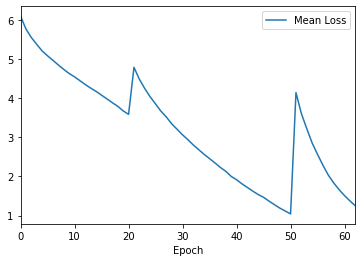

In [29]:
pd.DataFrame(mean_losses, columns=["Epoch", "Mean Loss"]).set_index("Epoch").plot()
plt.show()

As can be seen the mean loss has converged, but it is very high.

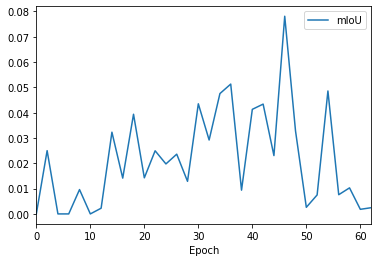

In [30]:
pd.DataFrame(mIoUs, columns=["Epoch", "mIoU"]).set_index("Epoch").plot()
plt.show()